In [ ]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

In [ ]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5

In [2]:
!pip install mljar-scikit-plot

In [4]:
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

2.5.1+cu121
0.20.1+cu121


In [5]:
photons = h5py.File('/kaggle/working/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
electrons = h5py.File('/kaggle/working/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
LENGHT = len(photons['X'])

In [6]:
dataset = np.concatenate((photons['X'], electrons['X'])).transpose(0,3,1,2)
labels = np.concatenate((photons['y'],  electrons['y']))

In [7]:
target = ['photon','electron']

print('label: ', labels[0])
print('so it\'s a jet of type: ',  target[np.argmax(labels[0])])

label:  0.0
so it's a jet of type:  photon


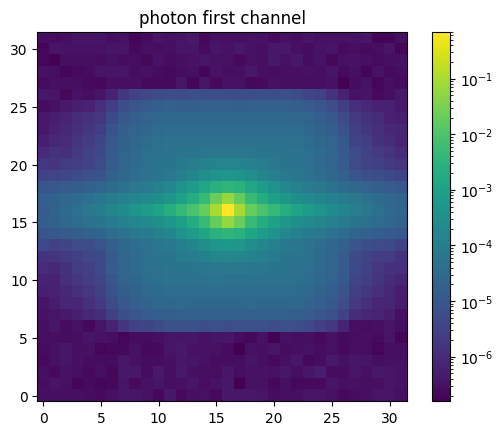

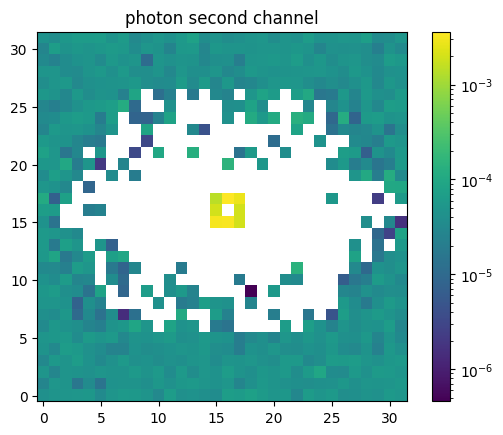

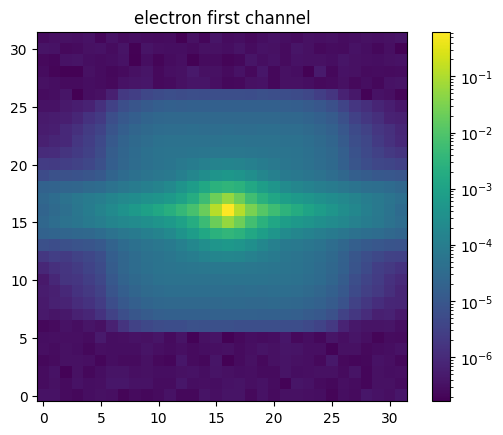

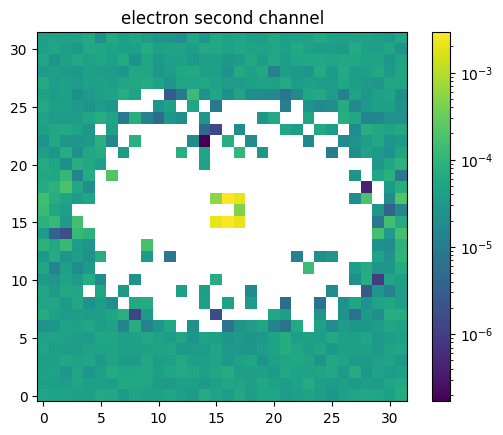

In [8]:
from matplotlib.colors import LogNorm


SUM_Image = np.sum(dataset[:LENGHT], axis = 0)
plt.imshow(SUM_Image[0]/float(LENGHT), origin='lower',norm=LogNorm())
plt.colorbar()
plt.title('photon first channel')
plt.show()
plt.imshow(SUM_Image[1]/float(LENGHT), origin='lower',norm=LogNorm())
plt.colorbar()
plt.title('photon second channel')
plt.show()

SUM_Image = np.sum(dataset[LENGHT:], axis = 0)
plt.imshow(SUM_Image[0]/float(LENGHT), origin='lower',norm=LogNorm())
plt.colorbar()
plt.title('electron first channel')
plt.show()
plt.imshow(SUM_Image[1]/float(LENGHT), origin='lower',norm=LogNorm())
plt.colorbar()
plt.title('electron second channel')
plt.show()

In [9]:
DATA_CUT = 50000
dataset = np.concatenate((photons['X'][:DATA_CUT], electrons['X'][:DATA_CUT])).transpose(0,3,1,2)
labels = np.concatenate((photons['y'][:DATA_CUT],  electrons['y'][:DATA_CUT]))

In [10]:
from sklearn.preprocessing import MinMaxScaler ,StandardScaler

scaler = StandardScaler()

# training, validation, test split
from sklearn.model_selection import train_test_split
test_frac = 0.2 # test set fraction
vali_frac = 0.25 # validation set fraction wrt training+validation

X_train,X_test,Y_train,Y_test = train_test_split(dataset,labels,test_size=test_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train, Y_train,test_size=vali_frac, shuffle=True, random_state=1234)

X_train = X_train.reshape(X_train.shape[0], 2, 32*32)
X_vali = X_vali.reshape(X_vali.shape[0], 2, 32*32)
X_test = X_test.reshape(X_test.shape[0], 2, 32*32)

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_vali.shape[1]):
    X_vali[:, i, :] = scalers[i].transform(X_vali[:, i, :])

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])


X_train = X_train.reshape(X_train.shape[0], 2, 32, 32)
X_vali = X_vali.reshape(X_vali.shape[0], 2, 32, 32)
X_test = X_test.reshape(X_test.shape[0], 2, 32, 32)


print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_vali shape: ',X_vali.shape)
print('Y_vali shape: ',Y_vali.shape)
print('X_vali shape: ',X_test.shape)
print('Y_vali shape: ',Y_test.shape)

X_train shape:  (60000, 2, 32, 32)
Y_train shape:  (60000,)
X_vali shape:  (20000, 2, 32, 32)
Y_vali shape:  (20000,)
X_vali shape:  (20000, 2, 32, 32)
Y_vali shape:  (20000,)


In [11]:
X_train_pt = torch.Tensor(X_train)
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali)
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test)
Y_test_pt = torch.Tensor(Y_test)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([60000, 2, 32, 32])
torch.Size([60000])
torch.Size([20000, 2, 32, 32])
torch.Size([20000])
torch.Size([20000, 2, 32, 32])
torch.Size([20000])


In [12]:
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.transforms import v2

class ContrastiveTransformations(object):
    def __init__(self, base_transforms):
        self.base_transforms = base_transforms

    def __call__(self, x):
        return self.base_transforms(x)

class ElectronPhoton(Dataset):
    """Electron-Photon dataset."""

    def __init__(self, data, labels, phase='train', transform=None):
        """
        Args:
            data: torch tensor containing images
            labels: torch tensor containing associated label
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.phase = phase
        self.data = data
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        label = self.label[idx]

        if self.transform:
          if self.phase == 'train':
            sample = self.transform(sample)
          else:
            sample = sample

        return sample, label

# Data-augmentation transformations
# compose 4 different transformations from the trochvision lib: random horizontal pixels flip, random vertical pixels flip, random rotation, and random crop of the image

contrast_transforms = transforms.Compose([v2.RandomHorizontalFlip(),
                                          v2.RandomVerticalFlip(),
                                          v2.RandomRotation(180.),
                                          #v2.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1))
                                         ])

In [13]:
train_dataset = ElectronPhoton(data=X_train_pt, labels=Y_train_pt, phase='train', transform=ContrastiveTransformations( base_transforms=contrast_transforms))
val_dataset = ElectronPhoton(data=X_vali_pt, labels=Y_vali_pt, phase='vali')
test_dataset = ElectronPhoton(data=X_test_pt, labels=Y_test_pt, phase='vali')

In [14]:
from torch.utils.data import DataLoader
# We define a set of data loaders that we can use for various purposes later.
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, drop_last=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False, num_workers=0)

In [15]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, block_type='identity'):
        super(BasicBlock, self).__init__()
        self.block_type = block_type
        
        # First conv layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Middle conv layer (3x3)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Last conv layer
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
        # For conv block 
        if block_type == 'conv':
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            self.shortcut_bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        elif self.block_type == 'conv':
            residual = self.shortcut_bn(self.shortcut_conv(x))
        out += residual
        out = self.relu(out)
        
        return out

In [16]:
class ResNet15(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet15, self).__init__()
        
        # Conv1
        self.conv1 = nn.Conv2d(2, 32, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Conv2_x (CBx1/2)
        self.layer1 = self._make_layer(32, 64, stride=1, block_type='conv')
        
        # Conv3_x (CBx1/2)
        self.layer2 = self._make_layer(64, 128, stride=2, block_type='conv')
        
        # Conv4_x (CBx1/2)
        self.layer3 = self._make_layer(128, 256, stride=2, block_type='conv')
        
        # Conv5_x (CBx1/2)
        self.layer4 = self._make_layer(256, 512, stride=2, block_type='conv')
        
        # FC layer
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, in_channels, out_channels, stride=1, block_type='identity'):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        return BasicBlock(in_channels, out_channels, stride, downsample, block_type)
    
    def forward(self, x):
        # Conv1 + MaxPool
        x = self.conv1(x)  # [32×32]:32
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # [16×16]:32
        
        # Conv2_x
        x = self.layer1(x)  # [8×8]:64
        
        # Conv3_x
        x = self.layer2(x)  # [4×4]:128
        
        # Conv4_x
        x = self.layer3(x)  # [2×2]:256
        
        # Conv5_x
        x = self.layer4(x)  # [1×1]:512
        
        # Pooling and FC
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)  # Output: 2 classes
        
        return x

In [17]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  2
First GPU type:  Tesla T4
Computation device: cuda



In [18]:
model = ResNet15()
model= nn.DataParallel(model)
print(f"ResNet15 Architecture:")
print(model)

ResNet15 Architecture:
DataParallel(
  (module): ResNet15(
    (conv1): Conv2d(2, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(32

In [19]:
from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(2,32,32))
else:
  summary(model, input_size=(2,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           3,136
            Conv2d-2           [-1, 32, 32, 32]           3,136
       BatchNorm2d-3           [-1, 32, 32, 32]              64
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]           2,048
           Conv2d-10           [-1, 64, 16, 16]           2,048
      BatchNorm2d-11           [-1, 64, 16, 16]             128
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
             ReLU-14           [-1, 64,

In [20]:

model.to(device) #move the model on device (cpu/gpu)

xb,yb=next(iter(train_loader)) #take a mini batch from the trainign dataloader
xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
yb=yb.type(torch.long).to(device)
print(xb.shape)
print(yb.shape)

out=model(xb) #apply the model on the input batch
print(out.shape)

torch.Size([2048, 2, 32, 32])
torch.Size([2048])
torch.Size([2048, 2])


In [21]:
#loss
loss_func = nn.CrossEntropyLoss() #cross entropy loss

#metric accuracy from torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy
metric_func = MulticlassAccuracy(num_classes=2)
metric_func = metric_func.to(device)

# optimizer + lr schedular
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for step decay lr schedule
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)

In [22]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"Saving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [23]:
epochs = 150

import time

save_best_model = SaveBestModel() #initialize checkpoint function

# dfine python lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in train_loader: #takes a batch from the train dataloader
        counter += 1
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.long).to(device)

        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, yb) #compute loss
        metric = metric_func(pred, yb) #compute accuracy

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()

    # normalize loss and metric by number of batches
    train_loss = train_loss/(counter)
    train_metric = train_metric/(counter)

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # evaluation step (same as training but w/o backpropagation)

    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.long).to(device)
        pred = model(xb)
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()

    vali_loss = vali_loss/(counter)
    vali_metric = vali_metric/(counter)

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)

    elapsed_time = time.time()-t0
    current_lr = lr_scheduler.get_last_lr()[0]
    print("epoch: %d, time(s): %.2f, tloss: %.3f, tmetric: %.3f, vloss: %.3f, vmetric: %.3f, lr: %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))

    # update learning rate schedule
    lr_scheduler.step(vali_loss)


Best validation loss: 0.7017991542816162
Saving best model for epoch: 1

epoch: 1, time(s): 31.60, tloss: 0.727, tmetric: 0.518, vloss: 0.702, vmetric: 0.527, lr: 1.00e-03

Best validation loss: 0.6896115660667419
Saving best model for epoch: 2

epoch: 2, time(s): 30.86, tloss: 0.692, tmetric: 0.535, vloss: 0.690, vmetric: 0.549, lr: 1.00e-03

Best validation loss: 0.6868650019168854
Saving best model for epoch: 3

epoch: 3, time(s): 30.60, tloss: 0.688, tmetric: 0.547, vloss: 0.687, vmetric: 0.556, lr: 1.00e-03
epoch: 4, time(s): 30.29, tloss: 0.685, tmetric: 0.559, vloss: 0.689, vmetric: 0.555, lr: 1.00e-03

Best validation loss: 0.6850545227527618
Saving best model for epoch: 5

epoch: 5, time(s): 30.58, tloss: 0.682, tmetric: 0.562, vloss: 0.685, vmetric: 0.560, lr: 1.00e-03
epoch: 6, time(s): 30.34, tloss: 0.680, tmetric: 0.570, vloss: 0.689, vmetric: 0.558, lr: 1.00e-03

Best validation loss: 0.6809372007846832
Saving best model for epoch: 7

epoch: 7, time(s): 30.31, tloss: 0.6

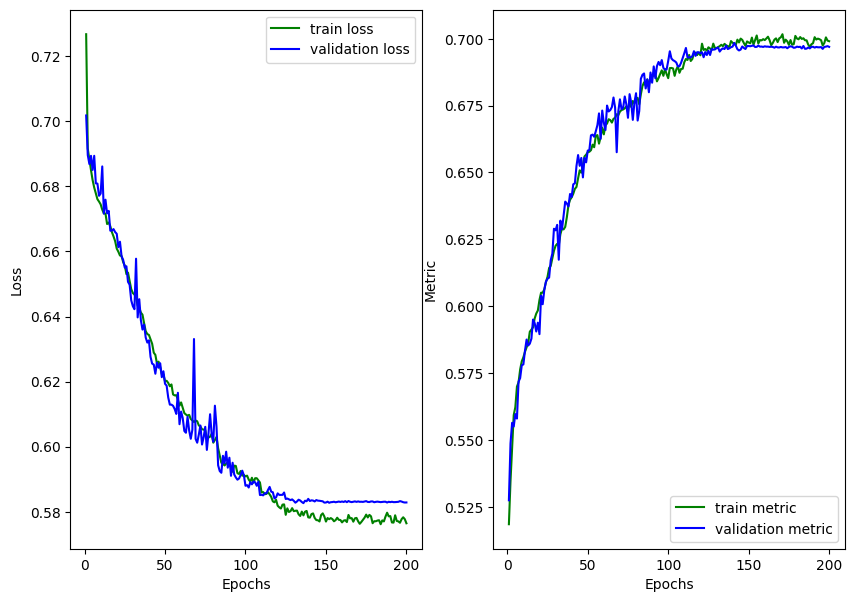

In [24]:
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [25]:
checkpoint = torch.load('./best_model.pth')
print('Best model at epoch: ', checkpoint['epoch'])

model = ResNet15()
model= nn.DataParallel(model)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Best model at epoch:  136


<ipython-input-25-edc02d52a3b4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./best_model.pth')


DataParallel(
  (module): ResNet15(
    (conv1): Conv2d(2, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1

In [26]:
# inference on test set
pred_prob = torch.empty(size=(0,2), device=device) #note the device parameter, this allows to create the torch tensors directly in the needed device
pred_val = torch.empty(size=(0,), device=device)
ground_truth = torch.empty(size=(0,), device=device)

model.to(device)

test_loss = 0.0
test_metric = 0.0

counter=0
with torch.no_grad():
  for xb, yb in test_loader:
    counter += 1
    xb=xb.type(torch.float).to(device)
    yb=yb.type(torch.long).to(device)
    res = model(xb)
    pre = torch.softmax(res, dim=1)
    val = pre.argmax(dim=1)
    pred_prob = torch.cat((pred_prob, pre), dim=0)
    pred_val = torch.cat((pred_val, val), dim=0)
    ground_truth = torch.cat((ground_truth, yb), dim=0)
    vloss = loss_func(res, yb)
    vmetric = metric_func(res, yb)
    test_loss += vloss.item()
    test_metric += vmetric.item()

test_loss = test_loss/(counter)
test_metric = test_metric/(counter)

predict_val = pred_val.cpu().data.numpy()
predict_prob = pred_prob.cpu().data.numpy()
true_val = ground_truth.cpu().data.numpy()

print('test loss: ', test_loss)
print('test average accuracy: ', test_metric)

test loss:  0.5865960955619812
test average accuracy:  0.6951008617877961


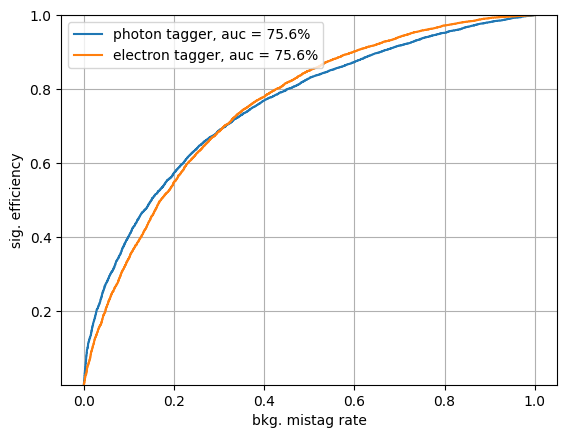

In [32]:
from sklearn.metrics import roc_curve, auc

# print ROC curves
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(target):
        fpr[label], tpr[label], threshold = roc_curve((true_val==i), predict_prob[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.ylabel("sig. efficiency")
plt.xlabel("bkg. mistag rate")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

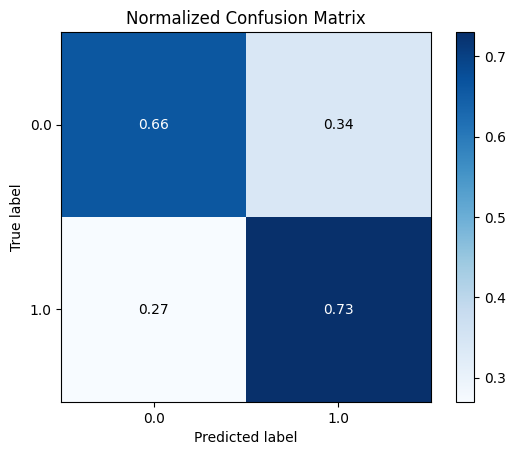

In [29]:
import scikitplot as skplt

plot = skplt.metrics.plot_confusion_matrix(true_val, predict_val, normalize=True)